<a href="https://colab.research.google.com/github/sayam47/ud120-projects/blob/master/FrozenLake_Mellowmax_vs_Boltzmann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from collections import deque
from collections import defaultdict
import gym
import sys
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [0]:
def interact(env, agent, num_episodes=5000, window=100):
    # initialize average rewards
    avg_rewards = deque(maxlen=num_episodes)
    # initialize best average reward
    best_avg_reward = -math.inf
    # initialize monitor for most recent rewards
    samp_rewards = deque(maxlen=window)
    # for each episode
    for i_episode in range(1, num_episodes+1):
        # begin the episode
        state = env.reset()
        # initialize the sampled reward
        samp_reward = 0
        while True:
            # agent selects an action
            action = agent.select_action(state)
            # agent performs the selected action
#             env.render()
            next_state, reward, done, _ = env.step(action)
            # agent performs internal updates based on sampled experience
            agent.step(state, action, reward, next_state, done)
            # update the sampled reward
            samp_reward += reward
            # update the state (s <- s') to next time step
            state = next_state
#             print("\rRewards : {}".format(samp_reward),end="")
            if done:
                # save final sampled reward
                samp_rewards.append(samp_reward)
                break
        
        avg_reward=0
        if (i_episode >= 100):
            # get average reward from last 100 episodes
            avg_reward = np.mean(samp_rewards)
            # append to deque
            avg_rewards.append(avg_reward)
            # update best average reward
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        averages_history.append(samp_reward)
        # check if task is solved (according to OpenAI Gym)
        if samp_reward >= 1:
#             print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            return i_episode
            break
#         if i_episode == num_episodes: print('\n')
    return 10000

In [0]:
from scipy.optimize import brentq

class Agent:

    def __init__(self, nA=4,omega=25,beta=1,mellow=0):
        self.mellow=mellow
        self.beta=beta
        self.nA = nA
        self.omega=omega
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.epsilon = 0
        self.decay = 0
        self.gamma = 0
        self.alpha = 0
        self.epsilon_function = None;
        self.next_value_function = None;
        #best score for self.init_for_sarsa() is 9.261 | slower to learn that q-learning
        #self.init_for_sarsa()
        #best score for self.init_for_q_learning is 9.26
        self.init_for_q_learning()
        #fixed epsilon=0.005 with alpha = 1 and gamma = 1 was very bad with a score of 8.655
        #current settings succeeded with 9.253
        #self.init_for_expected_sarsa()
    def init_for_sarsa(self):
        self.epsilon = 1
        self.decay = 0.5
        #discounted return rate
        self.gamma = 0.9
        #tendency to use recent event
        self.alpha = 0.1
        self.epsilon_function = self.decayed_epsilon
        def calculate(next_state):
            return self.Q[next_state][self.select_action(next_state)]
        self.next_value_function = calculate 
    def init_for_q_learning(self):
        self.epsilon = 1
        self.decay = 0.9
        #discounted return rate
        self.gamma = 0.9
        #tendency to use recent event
        self.alpha = 0.1
        self.epsilon_function = self.decayed_min_epsilon
        def calculate(next_state):
            return np.max(self.Q[next_state])
        self.next_value_function = calculate
    def init_for_expected_sarsa(self):
        self.epsilon = 0.05
        self.decay = 0.5
        #discounted return rate
        self.gamma = 0.8
        #tendency to use recent event
        self.alpha = 0.7
        self.epsilon_function = self.fixed_epsilon
        def calculate(next_state):
            policy_s = self.get_action_probability(next_state)
            next_action_value = np.dot(self.Q[next_state], policy_s)
            return np.max(self.Q[next_state])
        self.next_value_function = calculate
    def decayed_min_epsilon(self):
        self.epsilon = max(self.epsilon*self.decay,0.01)
    def decayed_epsilon(self):
        self.epsilon *= self.decay
    def mellowmax(self,beta,state):
        c=np.max(self.Q[state])
#         c = 0
        mellow=c+np.log(np.sum(np.exp(self.omega*(self.Q[state]-c)))/self.nA)/self.omega
        ans=np.sum(np.exp((self.Q[state]-mellow)*beta)*(self.Q[state]-mellow))
        return ans
    def fixed_epsilon(self):
        pass
    def get_action_probability(self, state):
#         policy_s = np.ones(self.nA) * self.epsilon / self.nA
#         #find the best action and assign it the other side of the probabiliy epsilon
#         best_action = np.argmax(self.Q[state])
#         policy_s[best_action] += 1 - self.epsilon
#         return policy_s
#         try:
#         except:
#             print(self.Q[state])
      
        if self.mellow==1:
            beta=brentq(self.mellowmax,-500,500,args=(state,))
        else:
            beta=self.beta
        policy_s = np.exp(beta*self.Q[state])/np.sum(np.exp(beta*self.Q[state]))
#         print(beta)
        return policy_s
    def select_action(self, state):
        policy_s = self.get_action_probability(state)
        return np.random.choice(np.arange(self.nA), p=policy_s)
    
    def step(self, state, action, reward, next_state, done):
        self.epsilon_function()
        next_action_value = 0
        if not done:
            next_action_value = self.next_value_function(next_state)
        self.Q[state][action] += self.alpha * (reward  + self.gamma * next_action_value - self.Q[state][action])

In [0]:
env = gym.make('FrozenLake-v0')


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
its=50
his_b=[]
solve_his_b=[]
for i in range(1,31):
    b=0
    for j in range(its):
        averages_history=[]
        agent = Agent(beta=i)
        agent.init_for_sarsa()
        sol=interact(env,agent)
        b+=sol
    b/=its
    solve_his_b.append(b)
#         his.append(averages_history)
    

In [0]:
its=50
his_m=[]
solve_his_m=[]
for i in range(1,31):
    b=0
    for j in range(its):
        averages_history=[]
        agent = Agent(omega=i,mellow=1)
        agent.init_for_sarsa()
        sol=interact(env,agent)
        b+=sol
    b/=its
    solve_his_m.append(b)
#         his.append(averages_history)
    

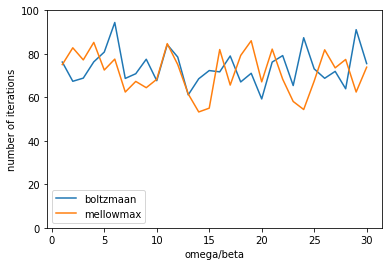

In [0]:
fig_best=plt.figure()
ax=fig_best.add_subplot(111)
# for i in range(1,31,5):
#     z=str(i)
#     plt.plot(np.arange(0,8),his[i//5][:8],label=z)
plt.plot(np.arange(1,31),solve_his_b,label='boltzmaan')
plt.plot(np.arange(1,31),solve_his_m,label='mellowmax')
plt.xlabel('omega/beta')
plt.ylabel('number of iterations')
plt.ylim(0,100)
plt.legend()
plt.savefig('lake.png')